# Analysis
### Table of Contents
- [Requirements](#requirements)

## Requirements

In [18]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import scipy.stats as stats
import darts
import ruptures as rpt

In [2]:
df = pd.read_csv('../../data/clean/clean.csv') # file path appears as `data/clean/clean.csv` in `analysis.py`

## Correlation

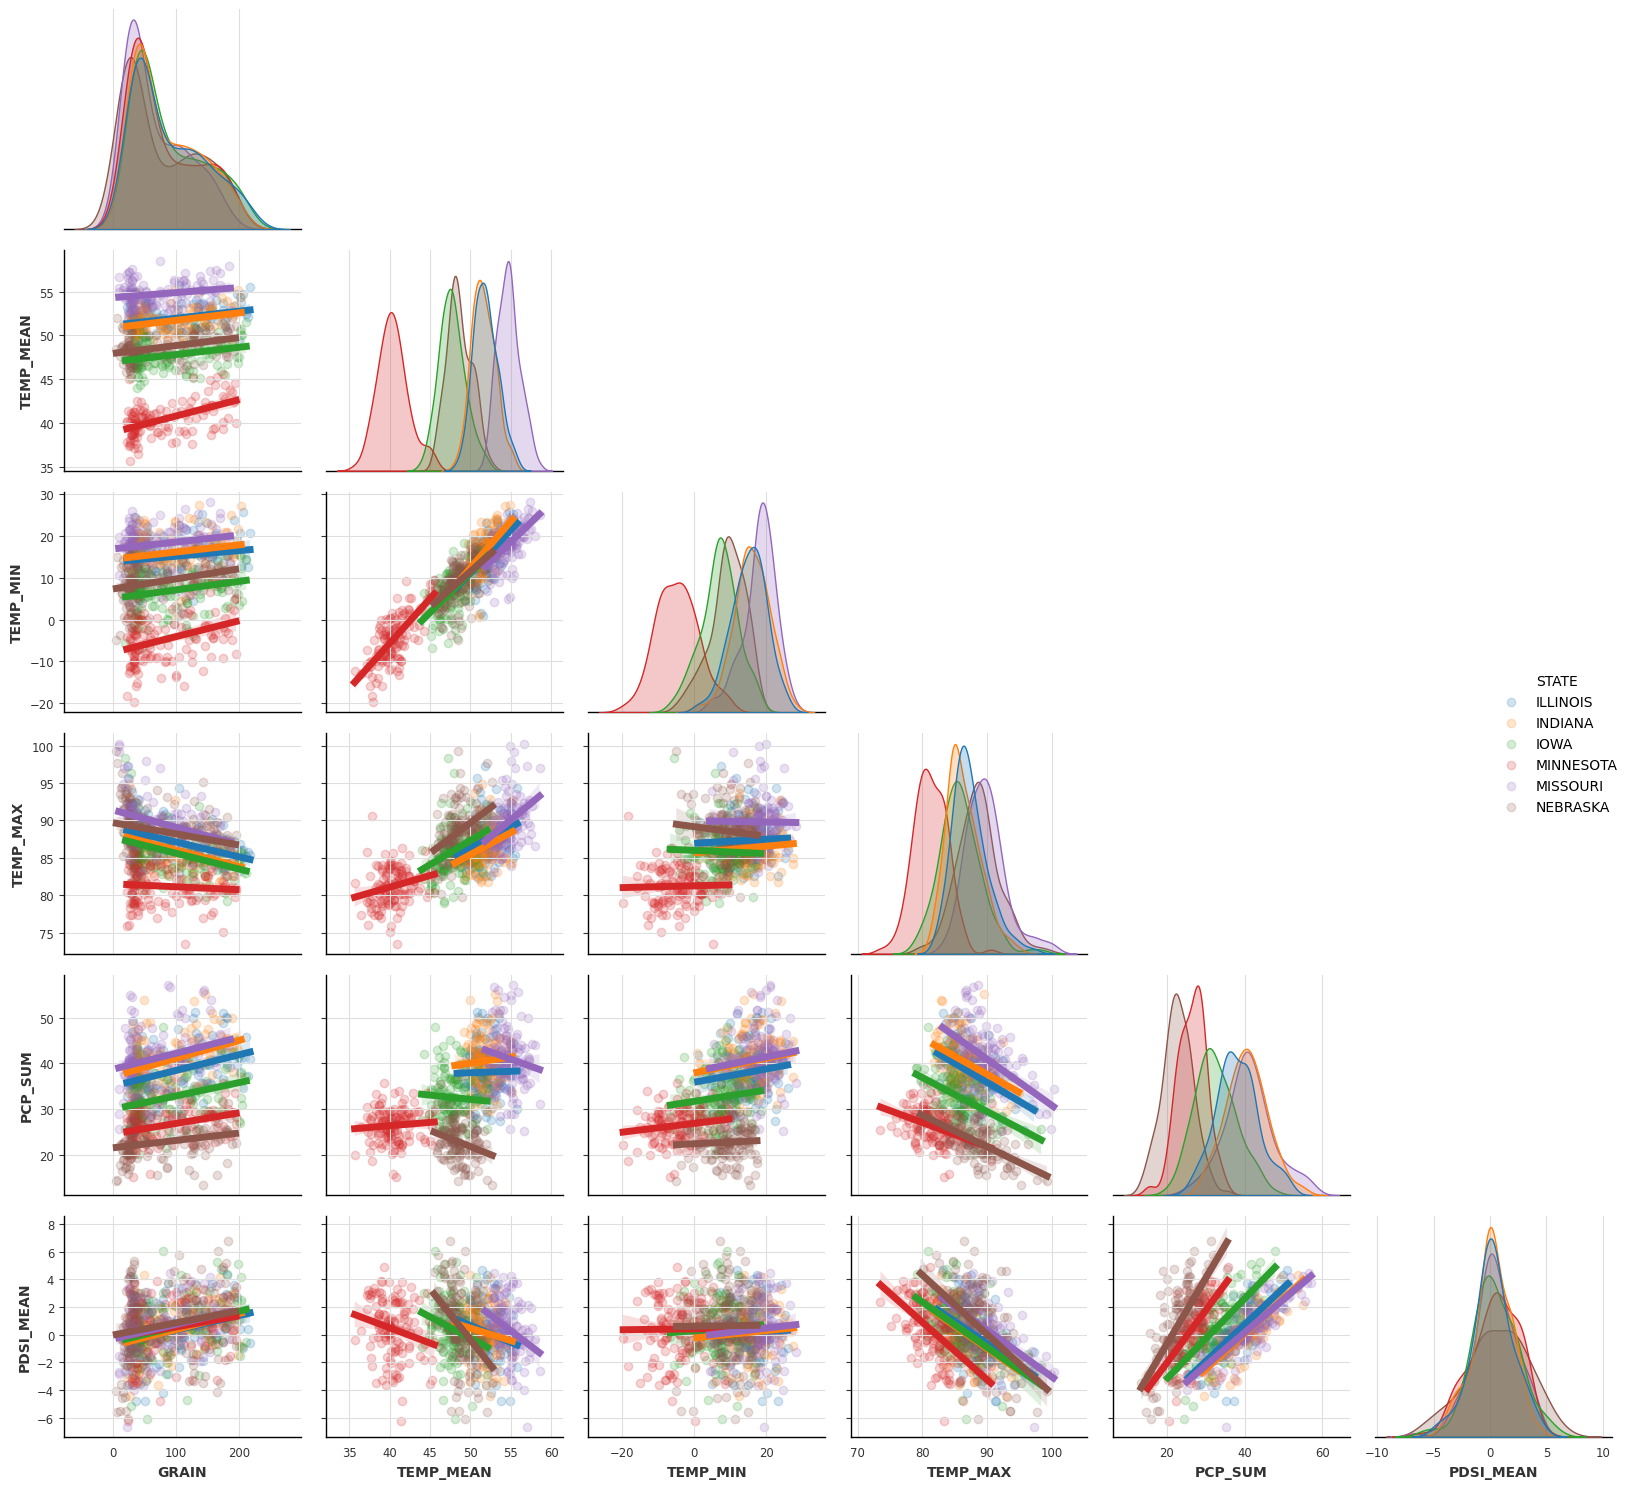

In [3]:
cols = ['GRAIN', 'TEMP_MEAN', 'TEMP_MIN', 'TEMP_MAX', 'PCP_SUM', 'PDSI_MEAN']
sns.pairplot(
    df.drop(columns='YEAR'),
    corner=True, kind='reg', diag_kind='kde',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(cols)],
    plot_kws={
        'line_kws':{'linewidth':5},
        'scatter_kws':{'alpha':0.2}
    }
)
plt.tight_layout()
plt.savefig('../../results/analysis/pairplot_reg.png') # file path appears as `results/analysis/pairplot_reg.png` in `analysis.py`
plt.show()

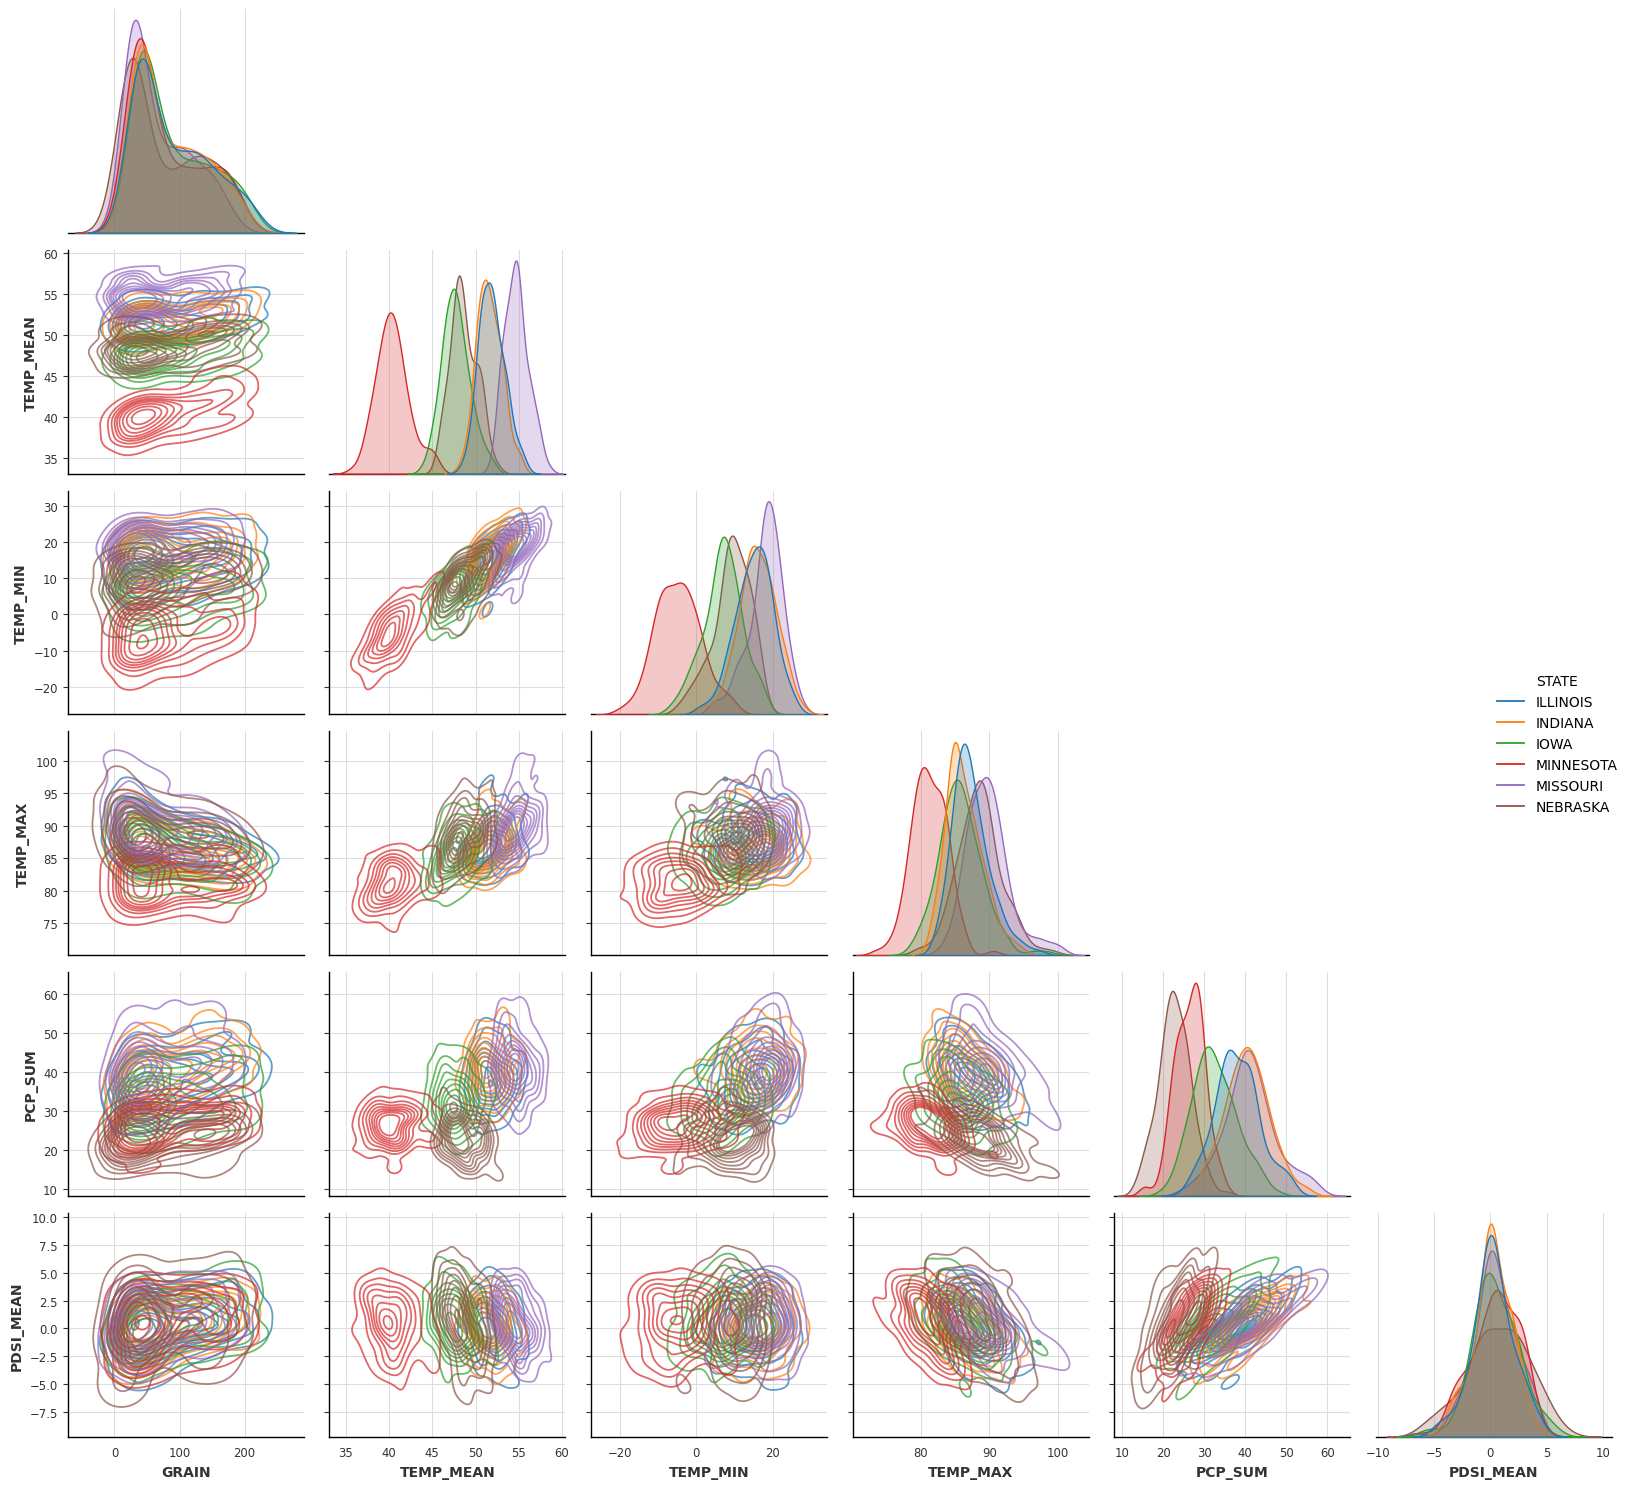

In [4]:
sns.pairplot(
    df.drop(columns='YEAR'),
    corner=True, kind='kde', diag_kind='kde',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(cols)],
    plot_kws={'multiple':'fill', 'alpha':0.7}
)
plt.tight_layout()
plt.savefig('../../results/analysis/pairplot_kde.png') # file path appears as `results/analysis/pairplot_kde.png` in `analysis.py`
plt.show()

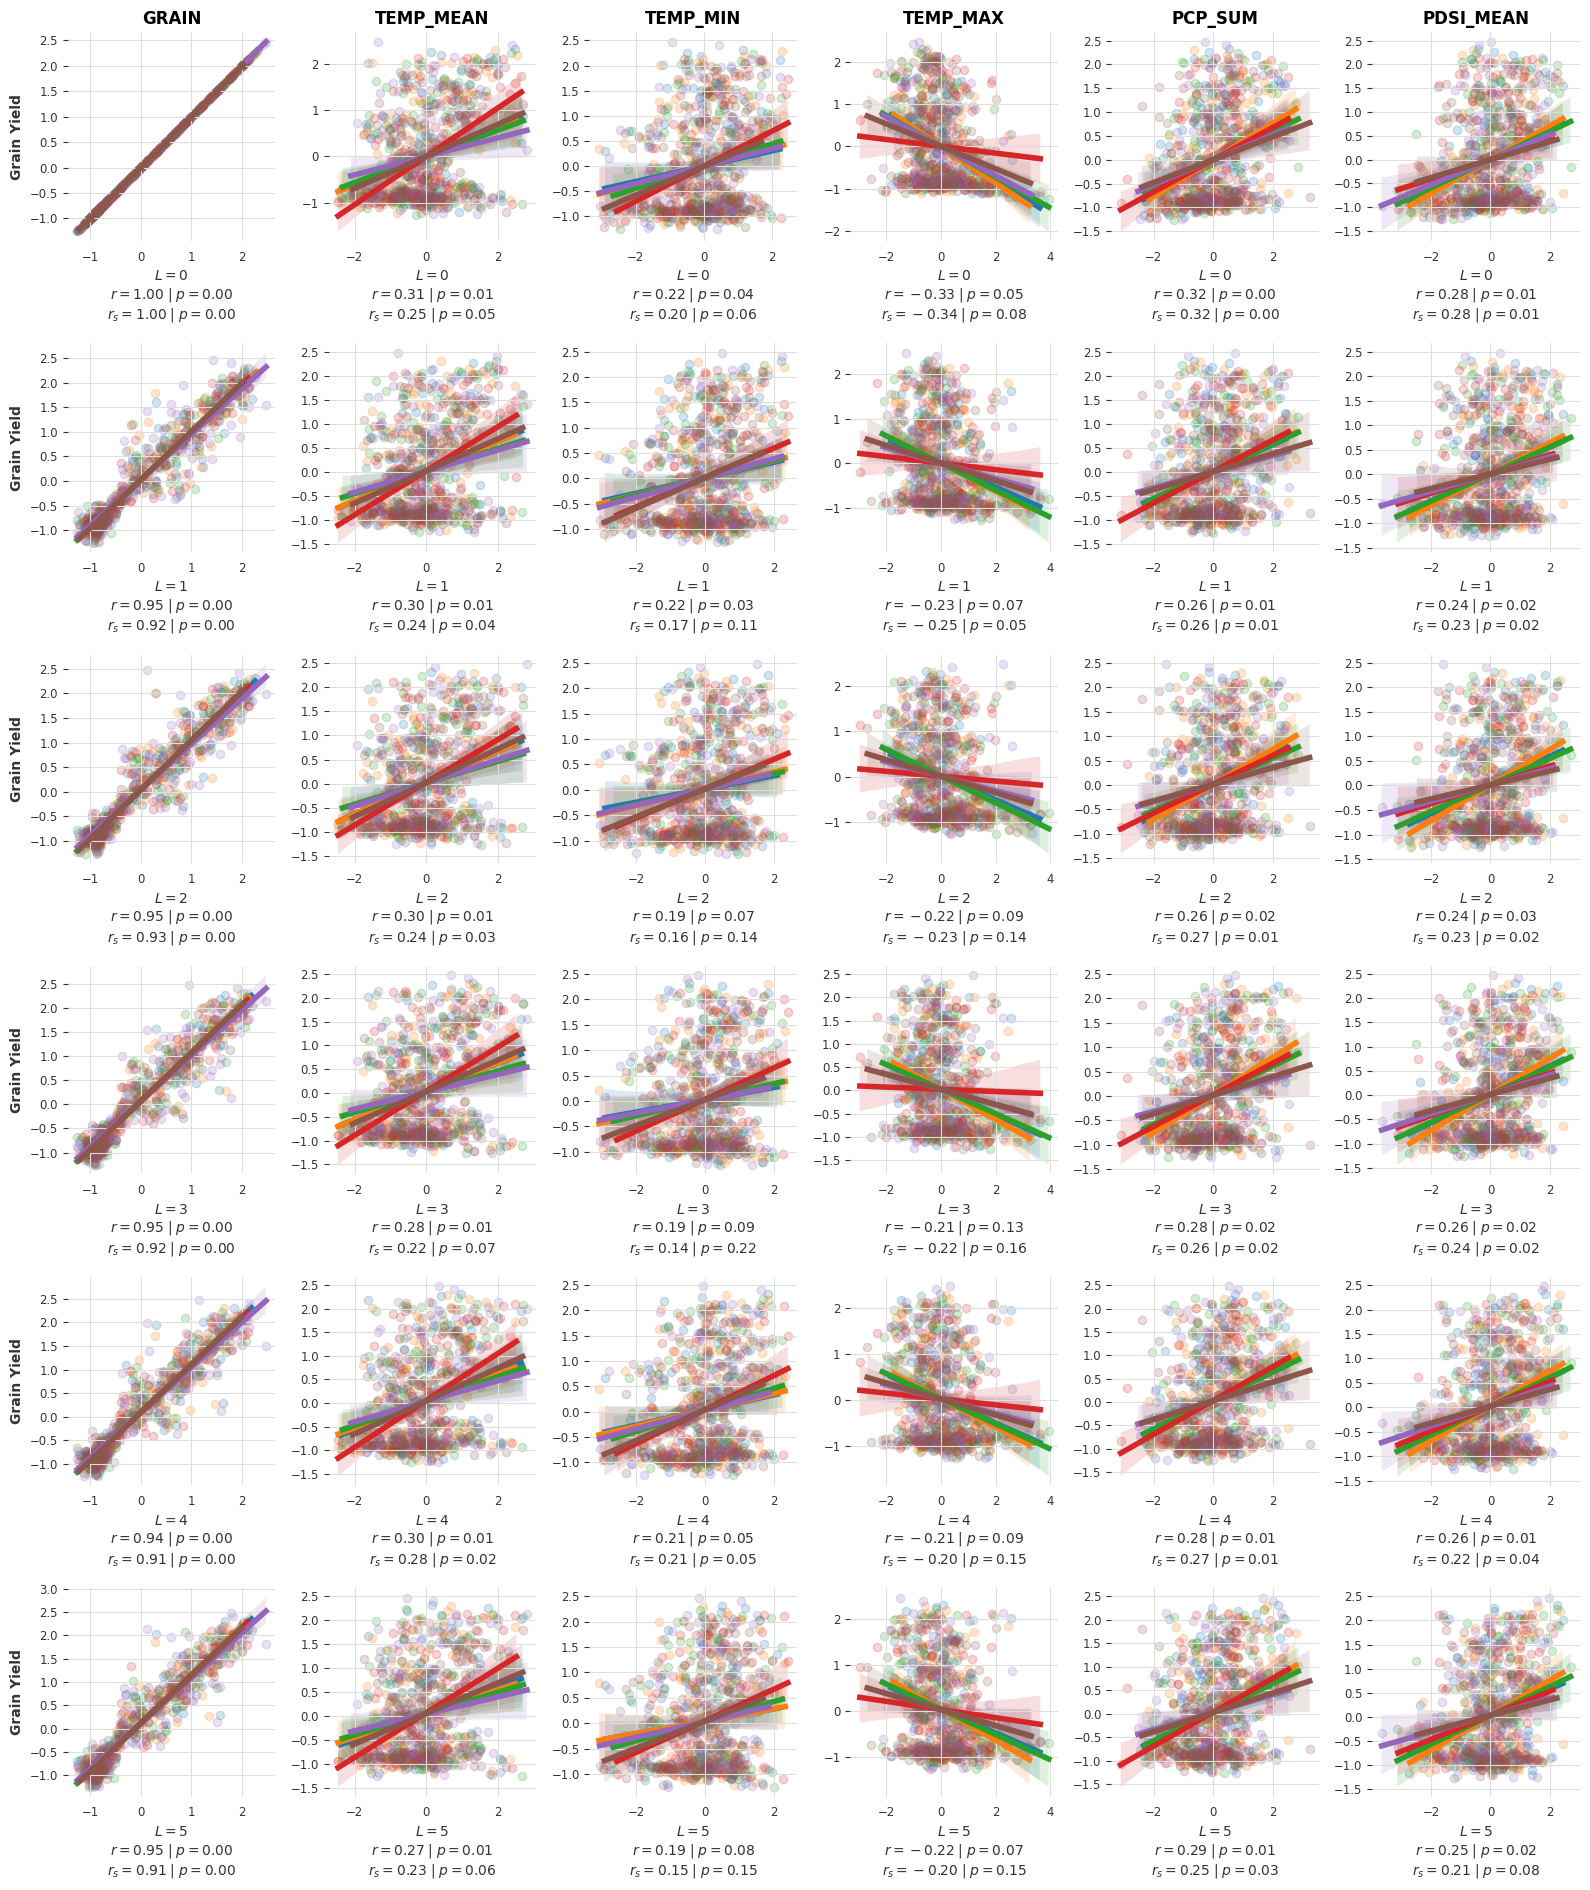

In [ ]:
lag_dict = {}
for col in cols:
    df_lagged = df.copy(deep=True)
    df_lagged[col] = df_lagged.groupby('STATE')[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    df_lagged['GRAIN'] = df_lagged.groupby('STATE')['GRAIN'].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    for lag in range(1, 6):
        df_lagged[f'{col}_LAG{lag}'] = df_lagged.groupby('STATE')[col].shift(lag)
    lag_dict[col] = df_lagged

fig, axes = plt.subplots(nrows=6, ncols=len(cols), figsize=(16, 19))
for i, col in enumerate(cols):
    data = lag_dict[col]
    for lag in range(6):
        ax = axes[lag, i]
        state_values = {}
        for state, color in zip(data['STATE'].unique(), list(mcolors.TABLEAU_COLORS.keys())[:len(cols)]):
            pearson_stat, pearson_p = stats.pearsonr(
                    x=data[data['STATE'] == state].dropna()[f'{col}_LAG{lag}' if lag != 0 else col],
                    y=data[data['STATE'] == state].dropna()['GRAIN']
                )
            spearman_stat, spearman_p = stats.spearmanr(
                    a=data[data['STATE'] == state].dropna()[f'{col}_LAG{lag}' if lag != 0 else col],
                    b=data[data['STATE'] == state].dropna()['GRAIN']
                )
            state_values[state] = (pearson_stat, pearson_p, spearman_stat, spearman_p)
            sns.regplot(
                ax=ax,
                data=data[data['STATE'] == state], x=f'{col}_LAG{lag}' if lag != 0 else col, y='GRAIN',
                scatter_kws={'alpha':0.2}, line_kws={'linewidth':4},
                label=state, color=color
            )
        ax.set_title(col if lag == 0 else '', fontweight='bold')
        ax.set_xlabel(
            f'$L = {lag}$\n'
            f'$r = {np.nanmean([v[0] for v in state_values.values()]):.2f} \;|\; p = {np.nanmean([v[1] for v in state_values.values()]):.2f}$\n'
            f'$r_s = {np.nanmean([v[2] for v in state_values.values()]):.2f} \;|\; p = {np.nanmean([v[3] for v in state_values.values()]):.2f}$'
        )
        ax.set_ylabel('Grain Yield' if i == 0 else '', fontweight='bold')
plt.tight_layout()
plt.savefig('../../results/analysis/lag_correlations.png') # file path appears as `results/analysis/lag_correlations.png` in `analysis.py`
plt.show()

In [16]:
ts = darts.TimeSeries.from_group_dataframe(
    df=df, group_cols='STATE', time_col='YEAR', value_cols=cols
)
darts.utils.statistics.plot_acf(
    
)

AttributeError: module 'darts.utils' has no attribute 'statistics'

In [22]:
ts

[<TimeSeries (YEAR: 130, component: 6, sample: 1)> Size: 6kB
 array([[[ 4.10000000e+01],
         [ 4.97083333e+01],
         [ 7.40000000e+00],
         [ 8.65000000e+01],
         [ 3.11500000e+01],
         [-1.68750000e+00]],
 
        [[ 4.20000000e+01],
         [ 5.22000000e+01],
         [ 2.08000000e+01],
         [ 8.58000000e+01],
         [ 3.59500000e+01],
         [ 3.40833333e-01]],
 
        [[ 3.40000000e+01],
         [ 5.14000000e+01],
         [ 1.57000000e+01],
         [ 8.76000000e+01],
         [ 3.57100000e+01],
         [-3.19166667e-01]],
 ...
        [[ 2.14000000e+02],
         [ 5.20583333e+01],
         [ 1.26000000e+01],
         [ 8.58000000e+01],
         [ 3.72500000e+01],
         [ 4.39166667e-01]],
 
        [[ 2.06000000e+02],
         [ 5.47416667e+01],
         [ 2.59000000e+01],
         [ 8.60000000e+01],
         [ 3.46500000e+01],
         [-9.92500000e-01]],
 
        [[ 2.17000000e+02],
         [ 5.55000000e+01],
         [ 2.07000000e+01

In [118]:
n_bkps = 3

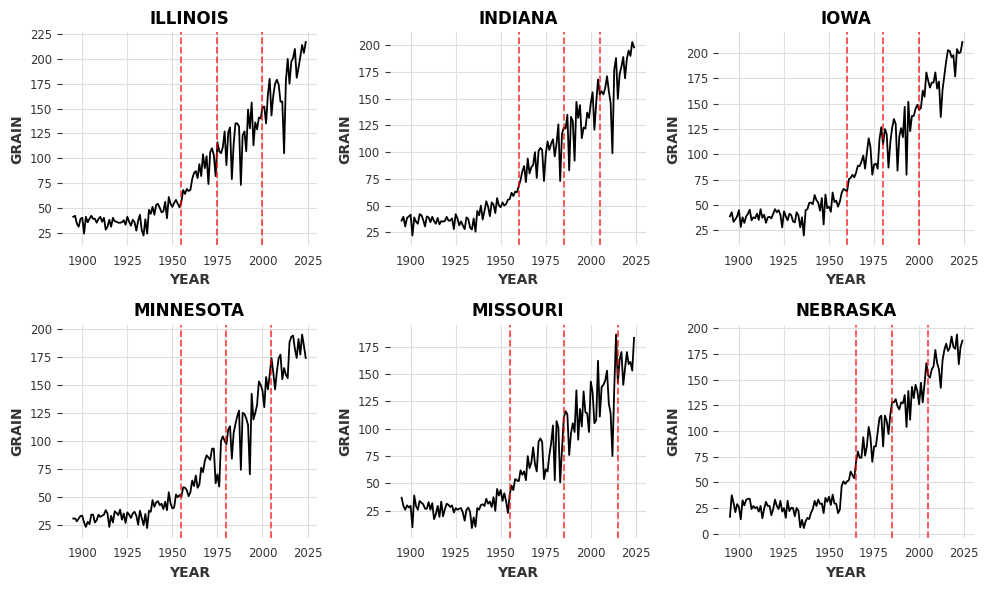

In [123]:
states = df['STATE'].unique()
fig, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(states)/2)), figsize=(10, 6))

for i, state in enumerate(states):
    
    ax = axes.flatten()[i]
    temp = df[df['STATE'] == state].reset_index(drop=True)
    data = temp['GRAIN'].values

    algo = rpt.Dynp(model='l1').fit(data)
    bkps = algo.predict(n_bkps=n_bkps)

    temp.loc[:, 'BKP'] = temp.index.isin(bkps) * 1
    sns.lineplot(
        ax=ax, data=temp, x='YEAR', y='GRAIN'
    )
    for bkp_year in temp[temp['BKP'] == 1]['YEAR']:
        ax.axvline(bkp_year, color='red', linestyle='--', alpha=0.7)
    ax.set_title(state, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/analysis/bkp_by_state.png') # file path appears as `results/analysis/bkp_by_state.png` in `analysis.py`
plt.show()

In [120]:
yield_dict = {}
for year in df['YEAR'].unique():
    for i, state in enumerate(df['STATE'].unique()):
        if i == 0:
            yield_dict[year] = {}
        yield_dict[year].update({state: float(df[(df['YEAR'] == year) & (df['STATE'] == state)]['GRAIN'].values[0])})
yield_df = pd.DataFrame(yield_dict).T.reset_index(names='YEAR')
yield_df['MEAN'] = yield_df.drop(columns='YEAR').mean(axis=1)

In [121]:
algo = rpt\
    .Dynp(model='l1')\
    .fit(
        yield_df\
            .drop(columns=['YEAR', 'MEAN'])\
            .to_numpy()
    )
bkps = algo.predict(n_bkps=n_bkps)
yield_df.loc[:, 'BKP'] = yield_df.index.isin(bkps) * 1
yield_df.loc[:, 'GROUP'] = yield_df['BKP'].cumsum()
yield_df.head()

YEAR  ILLINOIS  INDIANA  IOWA  MINNESOTA  MISSOURI  NEBRASKA       MEAN  \
0  1895      41.0     36.0  39.0       30.5      37.0      16.5  33.333333   
1  1896      42.0     39.5  43.0       30.5      29.5      37.5  37.000000   
2  1897      34.0     30.5  33.5       28.0      26.0      30.0  30.333333   
3  1898      31.0     38.5  36.0       30.5      30.0      21.0  31.166667   
4  1899      38.8     39.8  39.1       32.8      28.1      28.8  34.566667   

   BKP  GROUP  
0    0      0  
1    0      0  
2    0      0  
3    0      0  
4    0      0

1960
1985
2005


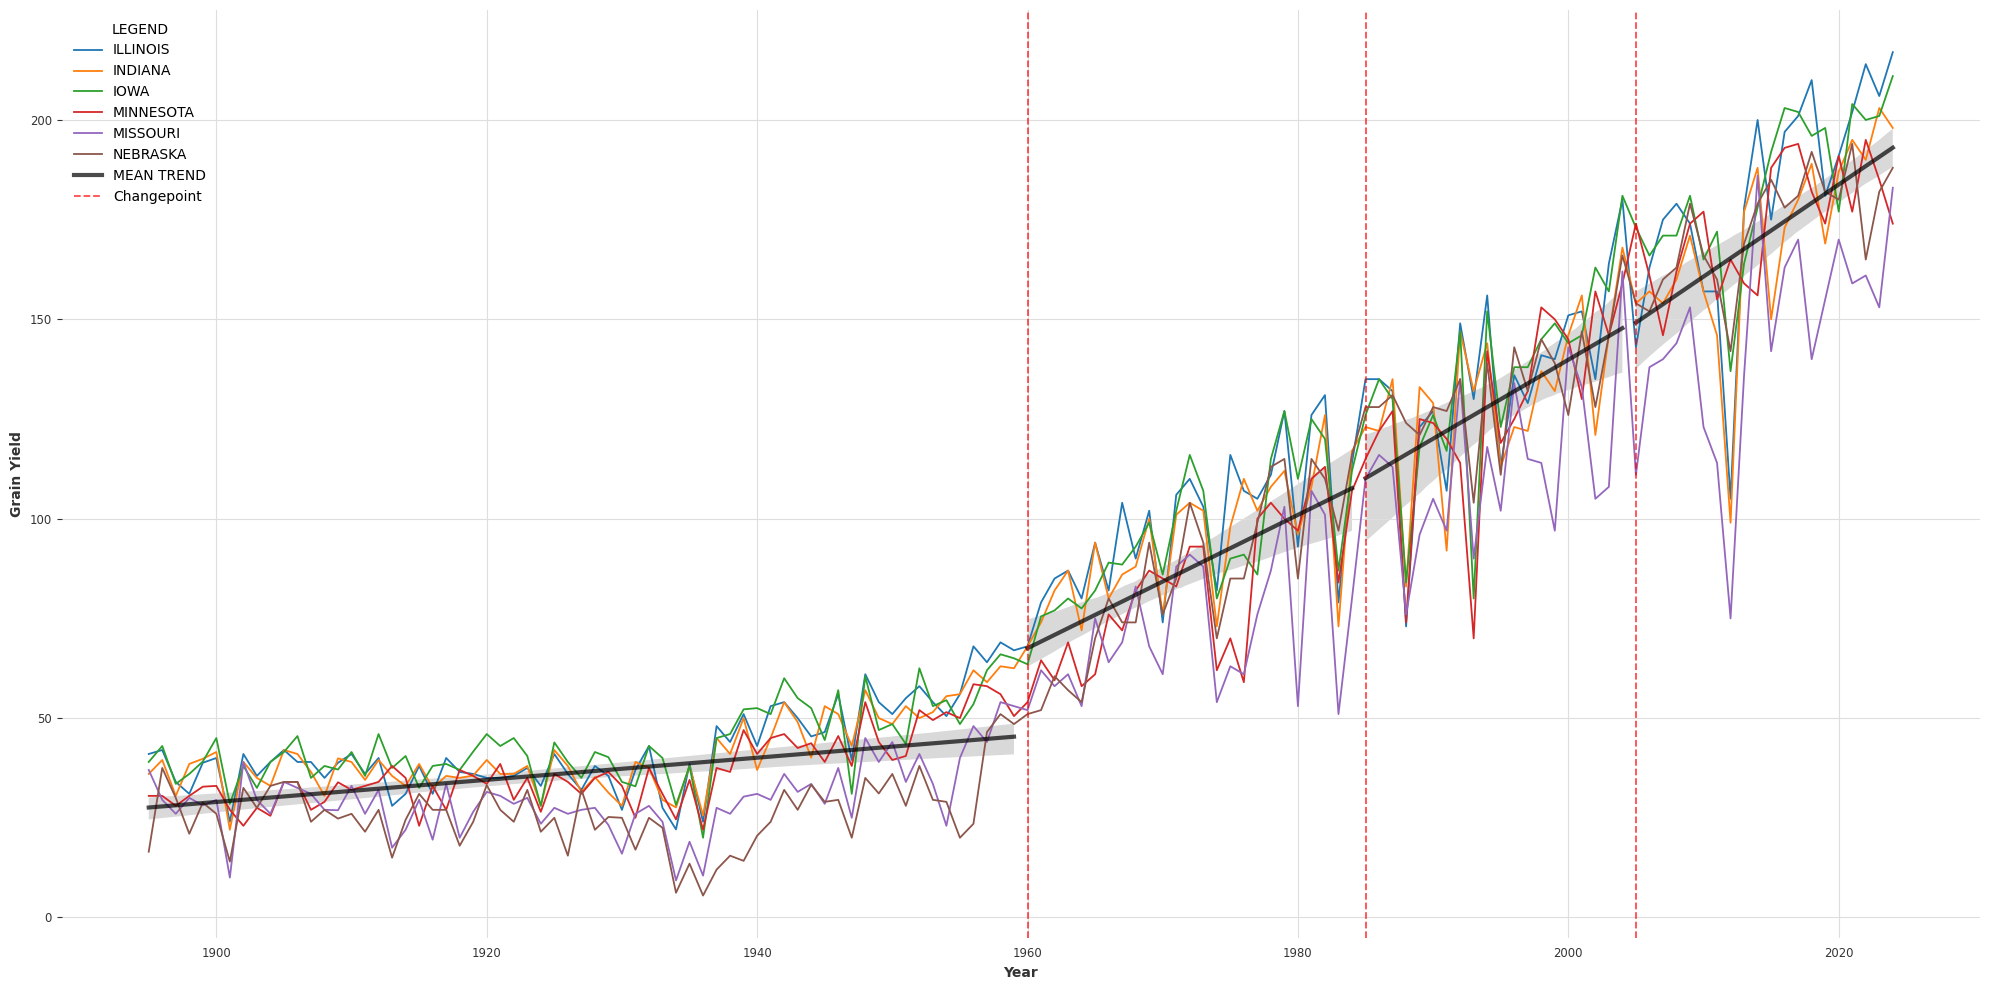

In [124]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    ax=ax, data=df,
    x='YEAR', y='GRAIN',
    hue='STATE', palette=list(mcolors.TABLEAU_COLORS.keys())[:len(states)]
)
for group in yield_df['GROUP'].unique():
    sns.regplot(
        ax=ax, data=yield_df[yield_df['GROUP'] == group],
        x='YEAR', y='MEAN',
        scatter=False, color='black', line_kws={'linewidth':3, 'alpha':0.7},
        label='MEAN TREND' if group == 0 else None
    )
for i, bkp_year in enumerate(yield_df[yield_df['BKP'] == 1]['YEAR']):
    print(bkp_year)
    ax.axvline(bkp_year, color='red', linestyle='--', alpha=0.7, label='Changepoint' if i == 0 else None)

ax.legend(title='LEGEND')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Grain Yield', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/analysis/bkp_tsplot.png') # file path appears as `results/analysis/bkp_tsplot.png` in `analysis.py`
plt.show()